In [1]:
import os
import sys
sys.path.append(os.path.abspath('../'))

import time
import scipy as sp
import numpy as np
import igraph as ig
from tqdm import tqdm
import networkx as nx
import NetworkingWithKuraPy as kp

from src.graph_analyzer import NetworkAnalyzer as na
from src.utils.graph_generator import GraphGenerator

# Kuramoto model on various graph model and real world networks
## Project for Bioinspired Systems 2024
---
#### 11 of December, 2024, Budapest
#### Kristóf Benedek
email: kristof.benedek@edu.bme.hu

## Introduction

Synchronization phenomena is fascinating and it occurs in our everyday life, more over it also governs numerous processes. Just think about opinion dynamics, traffic, applause, fireflies' flickering and neurons.

For different systems and dynamics several models are implemented and used. One such well-known model is the Kuramoto model. It comes in many flavours, generally building on two major variants, namely the first and second order Kuramoto model.



**The first-order Kuramoto model** describes the dynamics of $ N $ coupled oscillators. The equation is:

$$
\frac{d\theta_i}{dt} = \omega_i + \frac{K}{N} \sum_{j=1}^N \sin(\theta_j - \theta_i), \quad i = 1, 2, \dots, N
$$

- **Variables**:
  - $ \theta_i $: The phase of the $ i $-th oscillator.
  - $ \omega_i $: The natural frequency of the $ i $-th oscillator, drawn from a distribution (often Gaussian or uniform).
  - $ K $: Coupling strength that determines how strongly the oscillators interact.
  - $ N $: Total number of oscillators.

#### **Interpretation**:
1. **Natural Frequency** ($ \omega_i $):
   - Each oscillator has a natural tendency to oscillate at its own frequency.
2. **Coupling Term** ($ \frac{K}{N} \sum_{j=1}^N \sin(\theta_j - \theta_i) $):
   - Oscillators influence each other through this term. If $ K > 0 $, they tend to synchronize by pulling their phases closer.
3. **Behavior**:
   - At low coupling ($ K $), oscillators remain desynchronized.
   - At high coupling, synchronization emerges, where oscillators align their phases or move coherently.
   - A phase transition from incoherence to partial or full synchronization occurs as $ K $ increases.

This first-order equation is widely used to study synchronization in coupled systems as brain, Jospehson junctions, opinion dynamics.


**The second-order Kuramoto model** includes an inertia term, which adds dynamics for systems where momentum or damping effects are significant. The equation is:

$$
m \frac{d^2 \theta_i}{dt^2} + \gamma \frac{d\theta_i}{dt} = \omega_i + \frac{K}{N} \sum_{j=1}^N \sin(\theta_j - \theta_i), \quad i = 1, 2, \dots, N
$$

- **Additional Variables**:
  - $ m $: Inertia or mass of the oscillators.
  - $ \gamma $: Damping coefficient.

#### **Interpretation**:
1. **Inertia Term** ($ m \frac{d^2\theta_i}{dt^2} $):
   - Introduces oscillatory inertia, relevant in systems where the oscillators resist changes to their velocities.
   - Examples: Power grids, mechanical oscillators, or systems with delayed adjustments.
2. **Damping Term** ($ \gamma \frac{d\theta_i}{dt} $):
   - Accounts for dissipation of energy, reducing the oscillators' velocities over time.
3. **Behavior**:
   - For low damping ($ \gamma $), the system can exhibit oscillatory or chaotic dynamics.
   - At high damping, the model simplifies to the first-order Kuramoto model.
   - The system can show richer synchronization behavior, such as frequency clustering or hysteresis effects.

---

### **Key Differences Between First and Second-Order Models**

| Aspect                  | First-Order Model                              | Second-Order Model                              |
|-------------------------|-----------------------------------------------|------------------------------------------------|
| Dynamics                | Simplified, phase-only evolution.             | Includes inertia and velocity effects.         |
| Applicability           | Systems where inertia is negligible.          | Systems with momentum or delayed adjustments.  |
| Synchronization Behavior| Phase transitions from incoherence to sync.    | Richer dynamics: oscillations, clustering.     |
| Complexity              | Easier to analyze and simulate.               | More complex but realistic in some contexts.   |

Both models have been widely used to study synchronization in various systems, from neuroscience to power grid stability and social dynamics.

## Aims

In this work I will attempt to investigate how synschronization dynamics is affected by the structure of the underlying system. This will mean in practice, that we will generate some synthetic graphs via some well-known methods such as:
- Erdős-Rényi
- Small-World
- Barabási-Albert (preferential attachement)
- Stohastic Block Method (SBM)

We will compare the synchronization dynamics with a few real world examples, such as:
- a road network of a city
- some brain netwrok
where the application of the Kuramoto model can be motivated.

In the first part we will compute some properties of the graphs, such as:
- centrality measures (mainly betweeness)
- degree distributions
- community structure (one method only: infomap) 
- diameter of the graph
- average degree
- clustering coefficient
- number of triangles

In the second part, we will simulate the Kuramoto model on these graphs and observe the synchronization dynamics. We will use the Kuramoto model implemented in the NetworkingWithKuraPy library developed by me and a colleague of mine. This repo is not yet public as it is still under development, for accessing or viewing the code please contact me.

---

## Part I - Analyzing the graphs



In [2]:
gen = GraphGenerator

# Erdős-Rényi graph
erdos_renyi_graph = gen.generate_erdos_renyi(n=100, m=200)
print("Erdős-Rényi graph generated with", len(erdos_renyi_graph.vs), "vertices and", len(erdos_renyi_graph.es), "edges.")

# Small-World graph
small_world_graph = gen.generate_small_world(n=100, k=4, p=0.1)
print("Small-World graph generated with", len(small_world_graph.vs), "vertices and", len(small_world_graph.es), "edges.")

# Barabási-Albert graph
barabasi_albert_graph = gen.generate_barabasi_albert(n=100, m=2)
print("Barabási-Albert graph generated with", len(barabasi_albert_graph.vs), "vertices and", len(barabasi_albert_graph.es), "edges.")

# Stochastic Block Model graph
sbm_graph = gen.generate_stochastic_block_model(n=100,sizes=[50, 50], p_matrix=[[0.1, 0.01], [0.01, 0.1]])
print("Stochastic Block Model graph generated with", len(sbm_graph.vs), "vertices and", len(sbm_graph.es), "edges.")


Erdős-Rényi graph generated with 100 vertices and 200 edges.
Small-World graph generated with 100 vertices and 200 edges.
Barabási-Albert graph generated with 100 vertices and 197 edges.
Stochastic Block Model graph generated with 100 vertices and 283 edges.


In [3]:
r = na.get_basic_properties(erdos_renyi_graph)
r['density']

0.04040404040404041

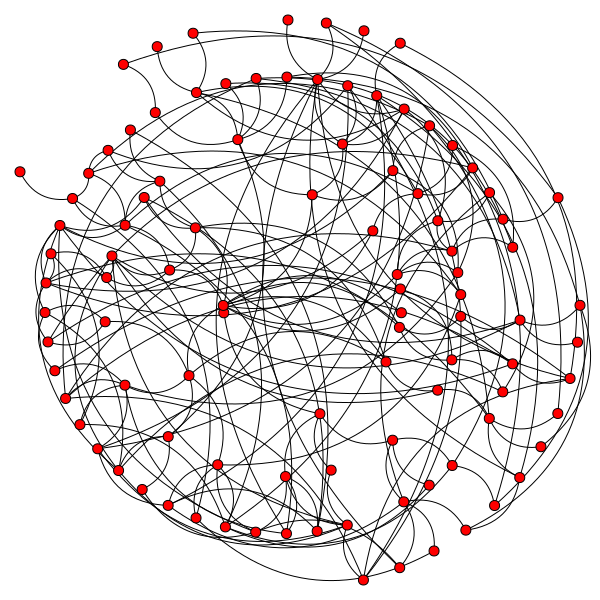

In [4]:
na.plot_graph(erdos_renyi_graph, savename='1.png', layout='rt_circular')

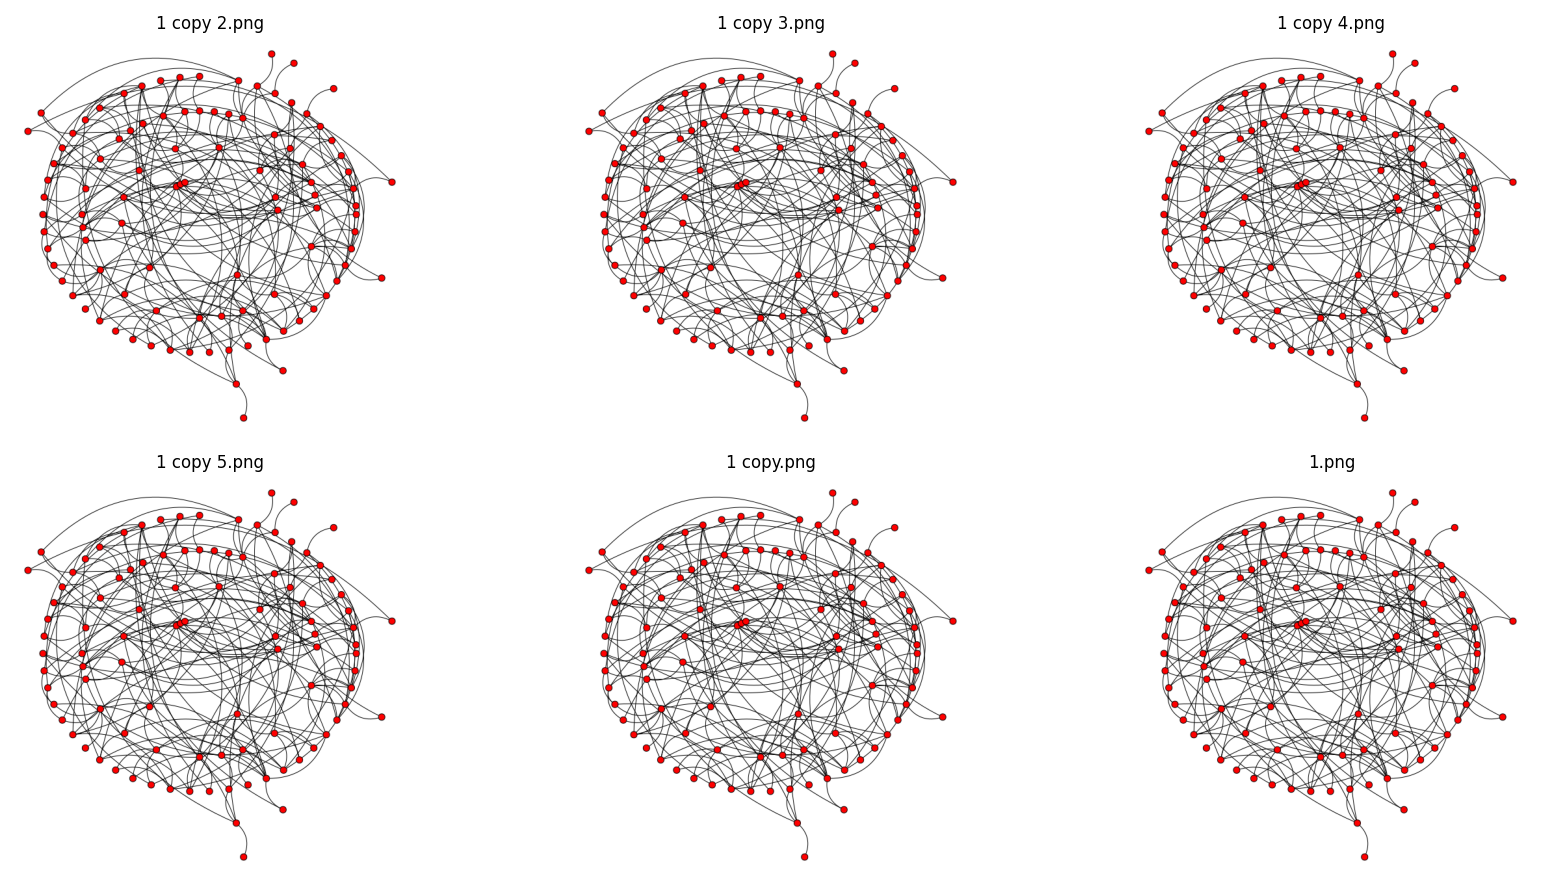

In [5]:
na.plot_images_from_folder("test_imgs", subplot_ratio=(2, 3))

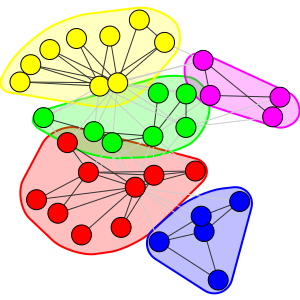

In [8]:
wtrap = g.community_walktrap(steps = 4)
clust = wtrap.as_clustering()
ig.plot(clust, mark_groups = True, bbox=(300,300))

Calculating Degree Centrality...
Calculating Closeness Centrality...
Calculating Betweenness Centrality...
Calculating Eigenvector Centrality...
Calculating PageRank...
Calculating Harmonic Centrality...
Calculating Load Centrality...
Calculating Katz Centrality...

Degree Centrality:
[16, 9, 10, 6, 3, 4, 4, 4, 5, 2, 3, 1, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 3, 3, 2, 4, 3, 4, 4, 6, 12, 17]

Closeness Centrality:
[0.5689655172413793, 0.4852941176470588, 0.559322033898305, 0.4647887323943662, 0.3793103448275862, 0.38372093023255816, 0.38372093023255816, 0.44, 0.515625, 0.4342105263157895, 0.3793103448275862, 0.36666666666666664, 0.3707865168539326, 0.515625, 0.3707865168539326, 0.3707865168539326, 0.28448275862068967, 0.375, 0.3707865168539326, 0.5, 0.3707865168539326, 0.375, 0.3707865168539326, 0.39285714285714285, 0.375, 0.375, 0.3626373626373626, 0.4583333333333333, 0.4520547945205479, 0.38372093023255816, 0.4583333333333333, 0.5409836065573771, 0.515625, 0.55]

Betweenness Centrality

In [39]:
nx.katz_centrality(g.to_networkx(), normalized=0)

{0: 4.982990167874235,
 1: 3.651807952026308,
 2: 4.121404970313236,
 3: 3.02264619887899,
 4: 1.890451152885133,
 5: 2.0310725862095724,
 6: 2.0310725862095724,
 7: 2.5778843937391853,
 8: 3.1126620496103867,
 9: 1.9260736983112348,
 10: 1.890451152885133,
 11: 1.4982988513286406,
 12: 1.8005633729257626,
 13: 3.0918177426521205,
 14: 1.940525684699041,
 15: 1.940525684699041,
 16: 1.4062144432532873,
 17: 1.8634795227437637,
 18: 1.940525684699041,
 19: 2.3774128716566985,
 20: 1.940525684699041,
 21: 1.8634795227437637,
 22: 1.940525684699041,
 23: 2.5865313998191013,
 24: 1.709114957015893,
 25: 1.7301052383631466,
 26: 1.7513648061217326,
 27: 2.3556382375697504,
 28: 2.226614397415866,
 29: 2.374315200245025,
 30: 2.6169724552331104,
 31: 3.005407880187569,
 32: 4.265924794404875,
 33: 5.139335226900585}

In [28]:
np.array(list(nx.degree_centrality(g.to_networkx()).values()))*(len(g.vs)-1)

array([16.,  9., 10.,  6.,  3.,  4.,  4.,  4.,  5.,  2.,  3.,  1.,  2.,
        5.,  2.,  2.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,  5.,  3.,  3.,
        2.,  4.,  3.,  4.,  4.,  6., 12., 17.])

## Resources

All real world (not generated) graphs come from external sources. The road networks were downloaded from/with [2] and the other networks were downloaded from [1].

## Code availability

The project source code is hosted at my [GitHub](https://github.com/)


1. Rossi, R. A., & Ahmed, N. K. (2015). The Network Data Repository with Interactive Graph Analytics and Visualization. Proceedings of the AAAI Conference on Artificial Intelligence. Retrieved from https://networkrepository.com
2. Boeing, (2017), OSMnx: A Python package to work with graph-theoretic OpenStreetMap street networks, Journal of Open Source Software, 2(12), 215, doi:10.21105/joss.00215
3. Acebrón, J. A., Bonilla, L. L., Pérez Vicente, C. J., Ritort, F., & Spigler, R. (2005). The Kuramoto model: A simple paradigm for synchronization phenomena. Review of Modern Physics, 77(1), 137–185. https://doi.org/10.1103/RevModPhys.77.137
4. [Wikipedia - Kuramoto model](https://en.wikipedia.org/wiki/Kuramoto_model) 